In [ ]:
from sqldb import QueryDB

In [ ]:
db = QueryDB()

## 1. CUSTOMER COUNT BY JOIN MONTH

In [4]:
qry = """
SELECT strftime('%Y-%m', CUSTOMER_JOIN_DATE) AS join_month, COUNT(*) AS customer_count, CUSTOMER_STATUS
FROM INFO
GROUP BY join_month, CUSTOMER_STATUS
"""
db.execute(qry)
#db.plot(qry, "join_month", "customer_count", "line")

,join_month,customer_count,CUSTOMER_STATUS
0,2021-07,2635,Active
1,2021-07,538,Deleted
2,2021-07,12,Pending DAO
3,2021-08,2537,Active
4,2021-08,422,Deleted
...,...,...,...
119,2024-09,29,Unverified
120,2024-10,1686,Active
121,2024-10,117,Deleted
122,2024-10,232,Pending DAO


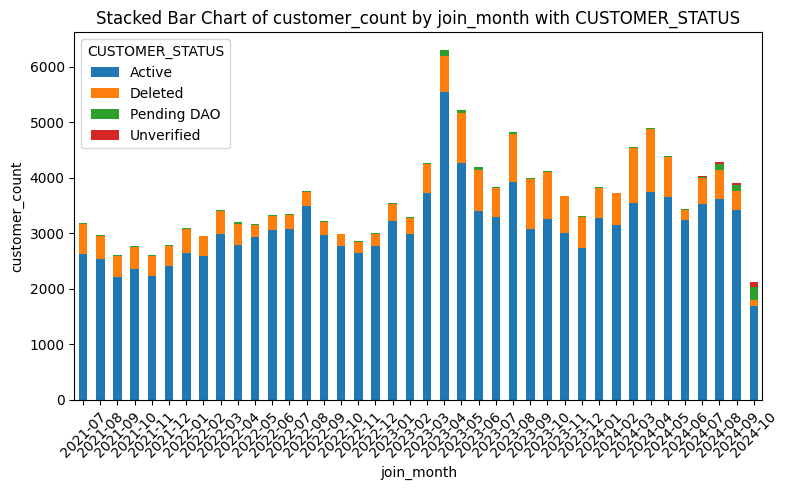

In [5]:
db.plot_stacked_bar(qry, "join_month", "customer_count", "CUSTOMER_STATUS")

Insights:
A stable core of active customers persists despite fluctuations, showing strong engagement.

2. AGE DISTRIBUTION

In [6]:
qry = """
SELECT 
    CASE 
        WHEN AGE < 18 THEN '0-17'
        WHEN AGE BETWEEN 18 AND 30 THEN '18-30'
        WHEN AGE BETWEEN 31 AND 50 THEN '31-50'
        ELSE '51+'
    END as AgeGroup,
    COUNT(*) as Count
FROM INFO
GROUP BY AgeGroup
"""
db.execute(qry)

,AgeGroup,Count
0,18-30,22436
1,31-50,33898
2,51+,88666


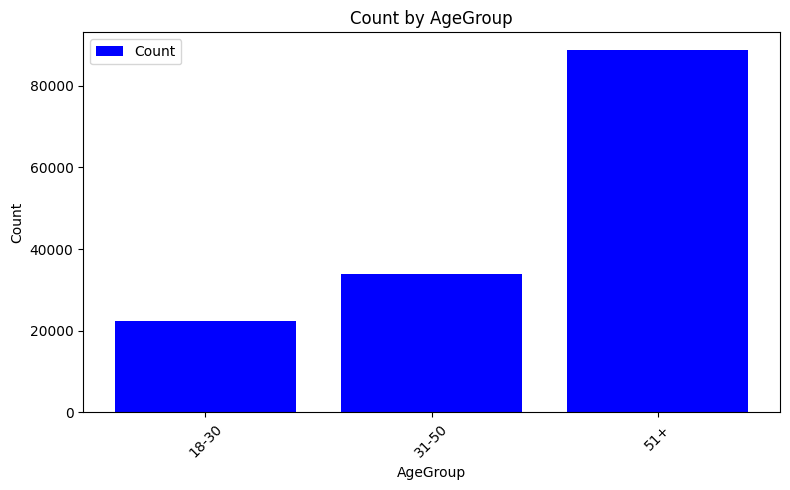

In [7]:
db.plot(qry, "AgeGroup", "Count", "bar")

Insights:
1.Marketing strategies should cater to older customers while also attracting younger users.
2.Understanding each age group's preferences can guide product development and promotional efforts.

3.loan and account engagement

In [8]:
qry = """
WITH customer_summary AS (
    SELECT 
        customer_type,
        COUNT(DISTINCT customer_id) AS total_customers,
        SUM(total_accounts) AS total_accounts,
        SUM(total_loans) AS total_loans,
        ROUND(AVG(age), 2) AS avg_age,
        SUM(CASE WHEN customer_status = 'Active' THEN 1 ELSE 0 END) AS active_customers,
        SUM(CASE WHEN customer_status = 'Deleted' THEN 1 ELSE 0 END) AS churned_customers
    FROM 
        INFO
          GROUP BY 
        customer_type
)

SELECT 
    customer_type,
    total_customers,
    total_accounts,
    total_loans,
    avg_age,
    active_customers,
    churned_customers,
    ROUND((active_customers * 1.0 / NULLIF(total_customers, 0)) * 100, 2) AS active_percentage,
    ROUND((churned_customers * 1.0 / NULLIF(total_customers, 0)) * 100, 2) AS churned_percentage,
    ROUND(total_loans * 1.0 / NULLIF(total_customers, 0), 2) AS loans_per_customer,
    ROUND(total_accounts * 1.0 / NULLIF(total_customers, 0), 2) AS accounts_per_customer
FROM 
    customer_summary;
"""
db.execute(qry)
#df= db.execute(qry)
#df.count()

,customer_type,total_customers,total_accounts,total_loans,avg_age,active_customers,churned_customers,active_percentage,churned_percentage,loans_per_customer,accounts_per_customer
0,Commercial,54465,172125,21563,48.10,48612,5638,89.25,10.35,0.40,3.16
1,Retail,90535,147255,19833,44.34,75818,13566,83.74,14.98,0.22,1.63


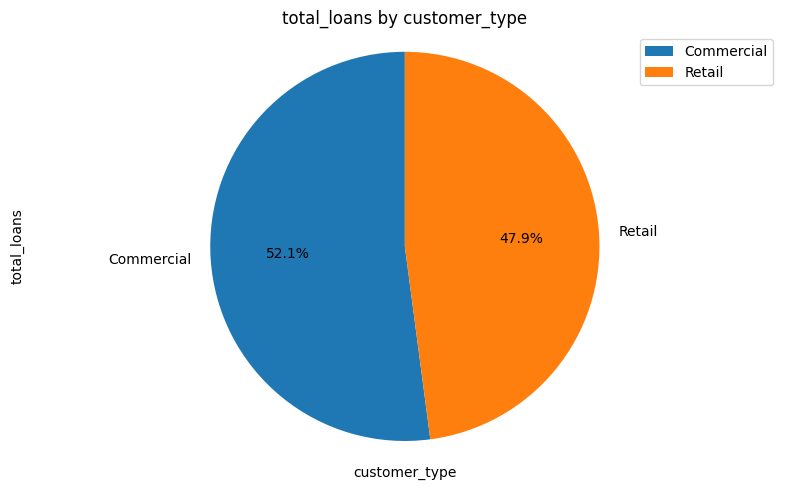

In [9]:
db.plot(qry,"customer_type","total_loans", "pie")

Insights:
1.Commercial customers average more accounts (3.16) than Retail customers (1.63).
2.They show stronger engagement and greater reliance on loans compared to Retail customers.

4.customer engagement

In [20]:
qry = """
SELECT 
    customer_type,
    COUNT(customer_id) AS total_customers,
    AVG(age) AS average_age,
    COUNT(CASE WHEN last_login_date IS NOT NULL THEN 1 END) AS active_customers,
    COUNT(CASE WHEN last_login_date IS NULL THEN 1 END) AS inactive_customers,
    SUM(total_accounts) AS total_accounts,
    SUM(total_loans) AS total_loans,
    AVG(year_to_date_estimated_income_amount) AS average_income,
    MAX(last_login_date) AS last_login_date
FROM 
    INFO
WHERE 
    customer_status = 'Active'
GROUP BY 
    customer_type
ORDER BY 
    total_customers DESC
"""
db.execute(qry)

,CUSTOMER_TYPE,total_customers,average_age,active_customers,inactive_customers,total_accounts,total_loans,average_income,last_login_date
0,Retail,75818,44.320719,75818,0,147184,19827,6.277642e+04,2024-10-15
1,Commercial,48612,48.122953,48612,0,170781,21474,1.218375e+06,2024-10-15


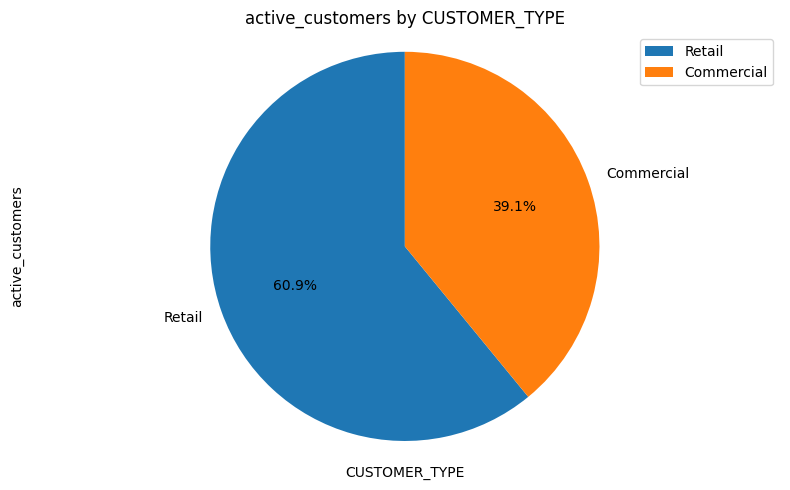

In [21]:
db.plot(qry,"CUSTOMER_TYPE","active_customers", "pie")

Insights : There are no inactive customers, which suggests that the business has been successful in maintaining customer interest and participation.

4.Churn Rate

In [12]:
qry = """
SELECT 
    customer_type,
    COUNT(customer_id) AS total_customers,
    COUNT(CASE WHEN customer_status = 'Deleted' THEN 1 END) AS churned_customers,
    COUNT(CASE WHEN customer_status = 'Active' THEN 1 END) AS active_customers,
    (COUNT(CASE WHEN customer_status = 'Deleted' THEN 1 END) * 1.0 / COUNT(customer_id)) * 100 AS churn_rate,
    AVG(age) AS average_age,
    SUM(total_accounts) AS total_accounts,
    SUM(total_loans) AS total_loans
FROM 
    INFO
GROUP BY 
    customer_type
ORDER BY 
    churn_rate DESC;
"""
db.execute(qry)

,CUSTOMER_TYPE,total_customers,churned_customers,active_customers,churn_rate,average_age,total_accounts,total_loans
0,Retail,90535,13566,75818,14.984260,44.344306,147255,19833
1,Commercial,54465,5638,48612,10.351602,48.097935,172125,21563


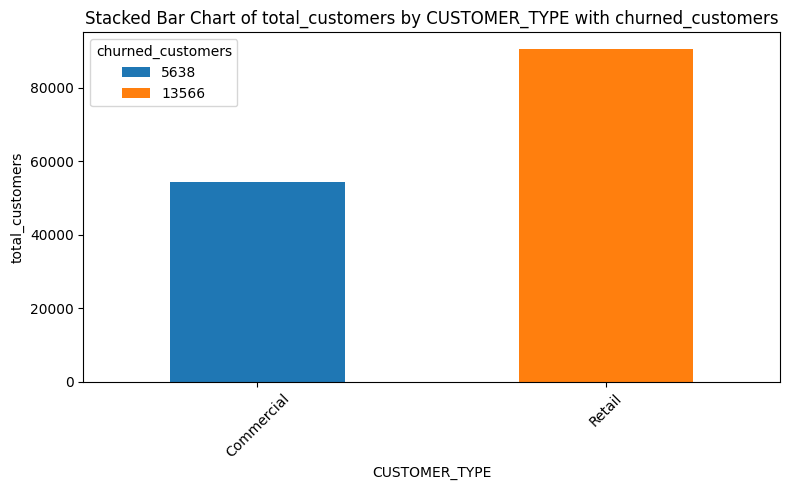

In [13]:
db.plot_stacked_bar(qry,"CUSTOMER_TYPE","total_customers", "churned_customers")

 Insights :  Retail customers have a higher churn rate indicating potential issues with retention in the Retail segment

6. Ranking

In [14]:
qry = """
WITH RankedCustomers AS (
    SELECT 
        customer_id,
        customer_type,
        total_accounts,
        total_loans,
        ROW_NUMBER() OVER (ORDER BY total_accounts DESC) AS account_rank,
        ROW_NUMBER() OVER (ORDER BY total_loans DESC) AS loan_rank,
        AVG(age) OVER () AS avg_age
    FROM 
        INFO
)

SELECT 
    customer_id,
    customer_type,
    total_accounts,
    total_loans,
    account_rank,
    loan_rank,
    avg_age
FROM 
    RankedCustomers
WHERE 
    account_rank <= 10 OR loan_rank <= 10
ORDER BY 
    total_accounts DESC, total_loans DESC
LIMIT 10;
"""
db.execute(qry)

,customer_id,customer_type,total_accounts,total_loans,account_rank,loan_rank,avg_age
0,31303687,Commercial,50,26,1,20,44.538825
1,31742667,Commercial,50,14,2,95,44.538825
2,31381576,Commercial,50,14,3,100,44.538825
3,31951636,Commercial,50,8,4,355,44.538825
4,1167531,Commercial,50,6,5,627,44.538825
5,237074,Commercial,50,2,6,4171,44.538825
6,678559,Commercial,50,2,7,4330,44.538825
7,132796,Commercial,50,2,8,5656,44.538825
8,2476678,Commercial,50,2,9,5912,44.538825
9,3769573,Commercial,50,1,10,8099,44.538825


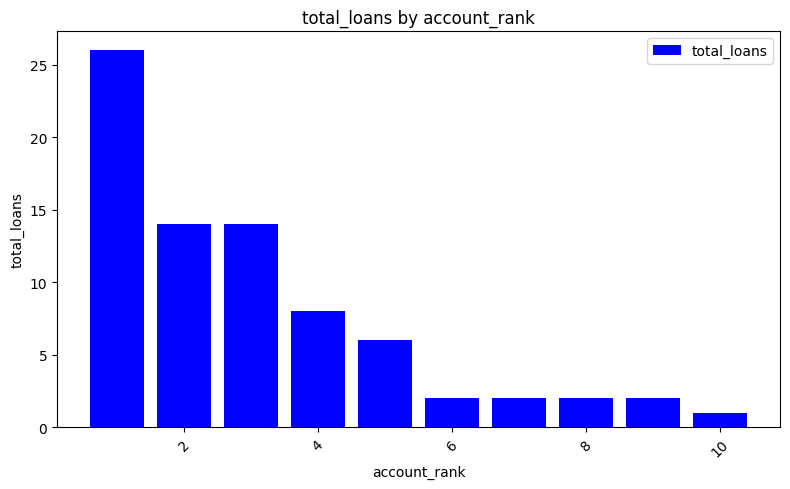

In [15]:
db.plot(qry, "account_rank", "total_loans", "bar")

Insights :
1. Customers with lower loan counts (like ID 3769573) might represent opportunities for cross-selling additional loan products or services.
2. Given the average age of 44.54, marketing strategies might be tailored to appeal to a more mature demographic,

7. Trend of High-Income Customers Over Time

In [17]:
qry = """
SELECT 
    strftime('%Y', CUSTOMER_JOIN_DATE) AS join_year, 
    CUSTOMER_STATUS,
    COUNT(*) AS high_income_count,
    AVG(YEAR_TO_DATE_ESTIMATED_INCOME_AMOUNT) AS avg_income
FROM 
    INFO
WHERE 
    YEAR_TO_DATE_ESTIMATED_INCOME_AMOUNT > (
        SELECT AVG(YEAR_TO_DATE_ESTIMATED_INCOME_AMOUNT) * 3 
        FROM INFO
    )
GROUP BY 
    join_year
ORDER BY 
    join_year;
"""
db.execute(qry)

,join_year,CUSTOMER_STATUS,high_income_count,avg_income
0,2021,Active,263,2.500166e+06
1,2022,Active,616,3.809350e+06
2,2023,Active,620,6.230457e+06
3,2024,Active,523,3.862186e+06


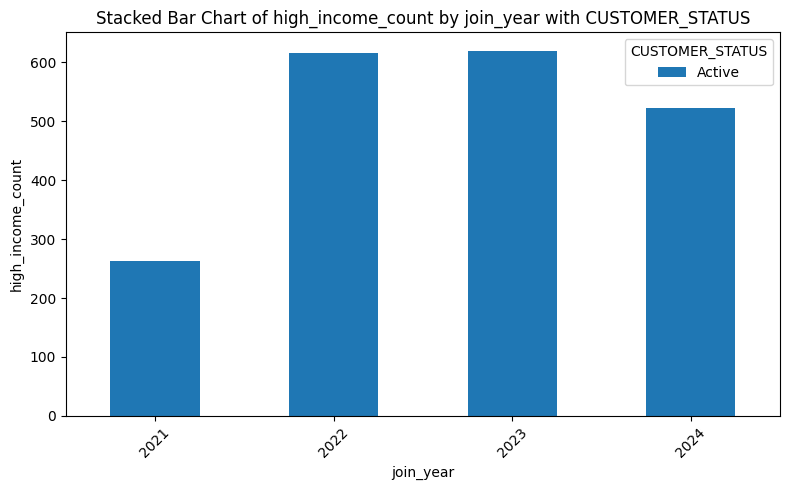

In [18]:
db.plot_stacked_bar(qry, "join_year", "high_income_count", "CUSTOMER_STATUS")

Insights : The average income of high-income customers rose significantly from 2021 to 2023, indicating more affluent new customers. However, a notable drop in 2024 suggests shifts in demographics or the inclusion of lower-income high earners.

8. Who are my customers?

In [16]:
# who are my customers
qry = """
WITH CustomerEngagement AS (
    SELECT
        customer_type,
        COUNT(*) AS total_customers,
        AVG(age) AS avg_age,
        SUM(total_accounts) AS total_accounts,
        SUM(total_loans) AS total_loans,
        COUNT(CASE WHEN customer_status = 'Active' THEN 1 END) AS active_customers
    FROM INFO
    GROUP BY customer_type
)

SELECT
    customer_type,
    total_customers,
    avg_age,
    total_accounts,
    total_loans,
    active_customers,
    (active_customers * 1.0 / total_customers * 100) AS active_percentage
FROM
    CustomerEngagement;
"""
db.execute(qry)

,customer_type,total_customers,avg_age,total_accounts,total_loans,active_customers,active_percentage
0,Commercial,54465,48.097935,172125,21563,48612,89.253649
1,Retail,90535,44.344306,147255,19833,75818,83.744408


Who are my customers?
The customer base comprises two primary segments:
1.Commercial customers, who are more engaged and tend to be older on average. They exhibit higher account and loan activity.
2.Retail customers, representing a larger group and being slightly younger.

Both segments show strong customer engagement, with high active percentages and a robust total customer base.